In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

#### Import Data

In [2]:
model_1_data = pd.read_csv('model_1/model_2_data.csv')

In [3]:
model_1_data = model_1_data.rename(columns = {'receipient_name':'recipient_name'})

In [4]:
cols = ['sk_match_id', 'frame', 'SoF', 'success', 'defender_box_count','player_name', 'pass_recipient_name', 'sk_player_id', 'receive_frame', 'player_1']

In [5]:
model_1_data.shape

(5652, 64)

In [6]:
model_1_data['team'] = model_1_data['team'].apply(lambda x: 1 if x == 'home' else 0)

In [7]:
sampled_df = (
    model_1_data.groupby('sk_match_id', group_keys=False)
      .apply(lambda group: group.sample(frac=0.6, random_state=42))
)

In [8]:
model_training = model_1_data.loc[model_1_data.index.difference(sampled_df.index)]

In [9]:
#model_df = model_1_data.copy()

In [46]:
features = ["score_diff", "SoF", "attacker_count", "team", "defender_box_count"]
target = "success"

In [47]:
model_df = model_training[features+[target]]

#### Viz

In [177]:
model_df.isna().sum()

score_diff            0
SoF                   0
attacker_count        0
team                  0
defender_box_count    0
success               0
dtype: int64

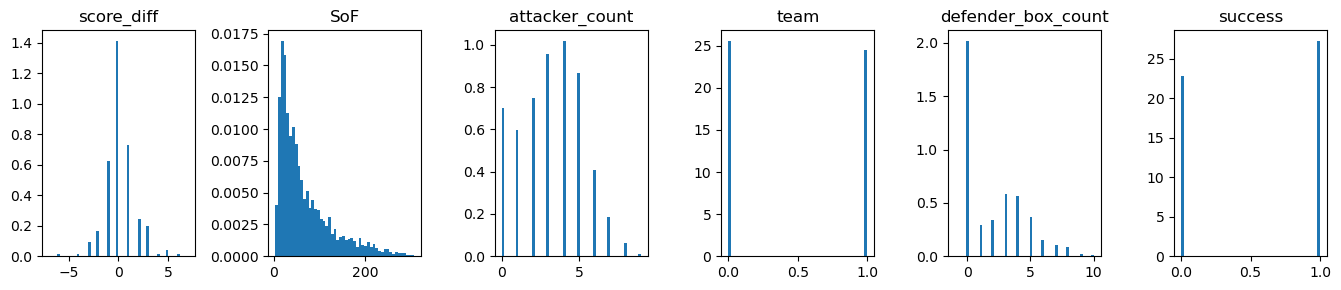

In [178]:
plt.figure(figsize=(18,3))

for i, col in enumerate(features+[target]):
    plt.subplot(1, 8, i+1)
    plt.hist(model_df[col], bins=50, density=True)
    plt.title(col)

plt.tight_layout()
plt.show()

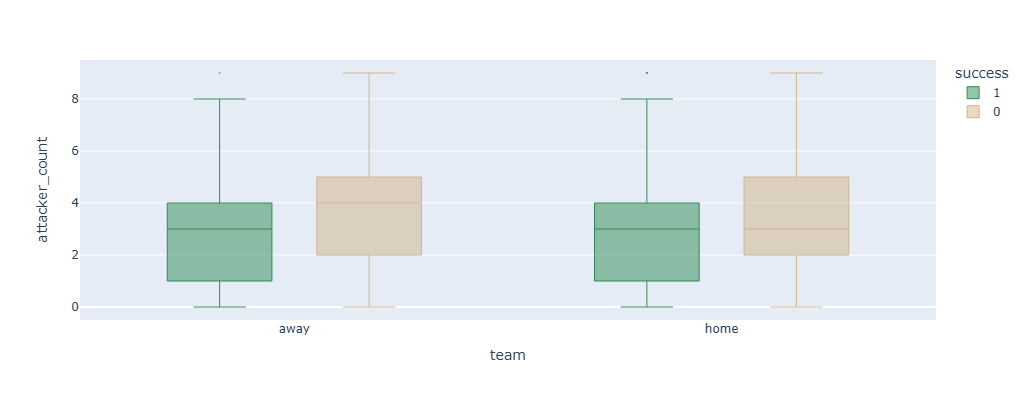

In [255]:
fig = px.box(
    model_1_data,
    x="team",
    y="attacker_count",
    color="success",
    color_discrete_map={1: "seagreen", 0: "tan"}  # Map specific colors
)

# Update the quartile method and style
fig.update_traces(
    quartilemethod="exclusive", marker=dict(size=1.5),
    line_width=1  # Remove edge lines
)
fig.update_layout(
    width=500,  # Set the width
    height=400  # Set the height
)

# Show the plot
fig.show()

In [4]:
model_1_data.columns

Index(['sk_match_id', 'frame', 'minute', 'player_name', 'pass_recipient_name',
       'pass_recipient_id', 'pass_recipient_position', 'sk_player_id',
       'pass_angle', 'type_primary', 'type_secondary', 'location_x',
       'location_y', 'pass_accurate', 'team_name', 'possession_team_name',
       'possession_team_name_src', 'possession_types', 'period',
       'receive_frame', 'receive_x', 'receive_y', 'target_area', 'ball_x_0',
       'ball_y_0', 'ball_x_1', 'ball_y_1', 'player_x_1', 'player_y_1',
       'player_1', 'ball_x_2', 'ball_y_2', 'player_x_2', 'player_y_2',
       'player_2', 'ball_x_3', 'ball_y_3', 'player_x_3', 'player_y_3',
       'player_3', 'sk_recipient_id', 'long_name', 'dist_0', 'dist_1',
       'dist_2', 'dist_3', 'score_1', 'score_2', 'score_3', 'attack_score',
       'defend_score', 'SoF', 'defender_box_count', 'attacker_count',
       'defender_count', 'team', 'paired_player_id', 'paired_player',
       'min_distance', 'MPD', 'score_diff', 'success', 'ball_dis

In [6]:
ManCity.sk_match_id.value_counts()

sk_match_id
1169170    130
1315114     91
1423691     91
1301698     72
1245010     69
1376029     68
1445378     67
1366200     64
1133200     56
1275862     45
1386129     41
1227049     40
1453349     36
1260792     30
1150609     23
1401804     23
1185376     20
Name: count, dtype: int64

In [3]:
ManCity = model_1_data[model_1_data['sk_match_id'].isin([1169170, 1315114, 1245010, 1301698])]

In [4]:
ManCity['sk_match_id'] = ManCity['sk_match_id'].astype('str')
ManCity.sk_match_id = ManCity.sk_match_id.astype('category')

In [5]:
ManCity['is_ManCity'] = ManCity['possession_team_name'].apply(lambda x: 'Yes' if x == 'Manchester City' else 'No')

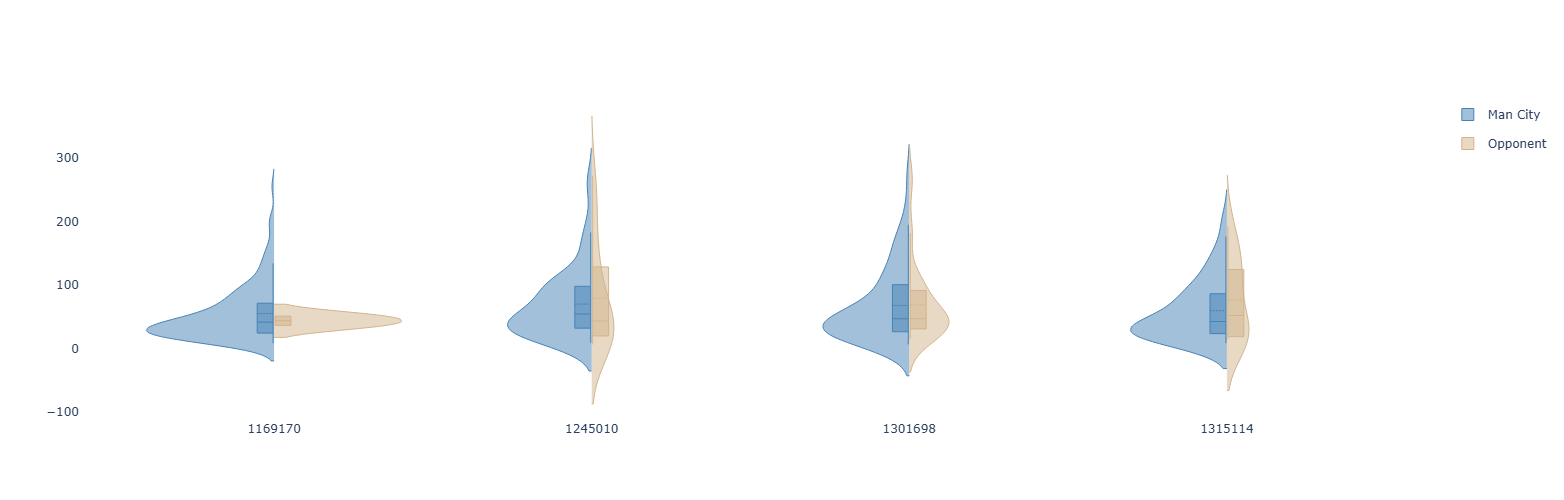

In [9]:
fig = go.Figure()

fig.add_trace(go.Violin(x=ManCity['sk_match_id'][ManCity['is_ManCity'] == 'Yes'],
                        y=ManCity['SoF'][ManCity['is_ManCity'] == 'Yes'],
                        legendgroup='Yes', scalegroup='Yes', name='Man City',
                        side='negative', width=0.8, box=dict(visible=True),
                        line_color='steelblue', line_width=1, points=False)
             )
fig.add_trace(go.Violin(x=ManCity['sk_match_id'][ManCity['is_ManCity'] == 'No'],
                        y=ManCity['SoF'][ManCity['is_ManCity'] == 'No'],
                        legendgroup='No', scalegroup='No', name='Opponent',
                        side='positive', width=0.8, points=False, box=dict(visible=True),
                        line_color='tan', line_width=1)
             )
# fig.add_annotation(
#     x=ManCity['sk_match_id'][ManCity['is_ManCity'] == 'Yes'].iloc[0],
#     y=man_city_median,
#     text=f"Median: {man_city_median:.2f}")
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0.7, violinmode='overlay', width = 1000, height = 500, plot_bgcolor='white')
fig.show()

In [73]:
match_id = 1315114
file_path = f'data/FA/match/{match_id}.json'
load_json_file(file_path)

{'id': 1315114,
 'home_team_score': 1,
 'away_team_score': 4,
 'date_time': '2023-12-17T13:00:00Z',
 'stadium': {'id': 1830,
  'name': 'Rossett Park',
  'city': 'Crosby',
  'capacity': 3185},
 'home_team': {'id': 2033,
  'name': 'Everton, Women',
  'short_name': 'Everton',
  'acronym': 'EVE'},
 'home_team_kit': {'id': 5454,
  'team_id': 2033,
  'season': {'id': 6,
   'start_year': 2019,
   'end_year': 2020,
   'name': '2019/2020'},
  'name': 'Home',
  'jersey_color': '#0000ff',
  'number_color': '#ffffff'},
 'away_team': {'id': 1835,
  'name': 'Manchester City, Women',
  'short_name': 'Man City, W',
  'acronym': 'MAN'},
 'away_team_kit': {'id': 6589,
  'team_id': 1835,
  'season': {'id': 8,
   'start_year': 2021,
   'end_year': 2022,
   'name': '2021/2022'},
  'name': 'Away',
  'jersey_color': '#ffffff',
  'number_color': '#000000'},
 'home_team_coach': None,
 'away_team_coach': None,
 'competition_edition': {'id': 574,
  'competition': {'id': 127,
   'area': 'ENG',
   'name': 'FA Wome

In [180]:
model_df[target].value_counts()

success
1    1231
0    1029
Name: count, dtype: int64

In [26]:
corr_df = model_df.rename(columns = {'team':'home vs away'})

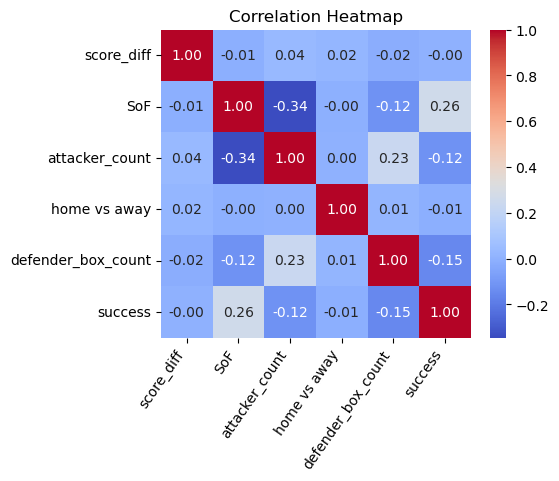

In [38]:
correlation_matrix = corr_df[['score_diff', 'SoF', 'attacker_count', 'home vs away', 'defender_box_count'] + [target]].corr()
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.xticks(rotation=55, ha="right")
plt.show()

#### Model

In [48]:
X = model_df[features]
y = model_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [49]:
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20],
        },
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=500),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["liblinear", "lbfgs"],
        },
    },
    "KNeighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
}

# Perform GridSearchCV for each model
best_models = {}
for name, entry in models.items():
    print(f"Optimizing {name}...")
    grid = GridSearchCV(entry["model"], entry["params"], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best cross-validated accuracy for {name}: {grid.best_score_:.4f}\n")

# Compare performance on the test set
print("Performance Comparison:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

Optimizing RandomForest...
Best params for RandomForest: {'max_depth': 10, 'n_estimators': 100}
Best cross-validated accuracy for RandomForest: 0.6268

Optimizing GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Best cross-validated accuracy for GradientBoosting: 0.6227

Optimizing LogisticRegression...
Best params for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validated accuracy for LogisticRegression: 0.6242

Optimizing KNeighbors...
Best params for KNeighbors: {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validated accuracy for KNeighbors: 0.6289

Optimizing XGBoost...
Best params for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best cross-validated accuracy for XGBoost: 0.6202

Performance Comparison:
Model: RandomForest
Accuracy: 0.6438
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.67      

Feature Importances for RandomForest:
              Feature  Importance
0                 SoF    0.529160
1  defender_box_count    0.151371
2          score_diff    0.142405
3      attacker_count    0.137578
4                team    0.039487


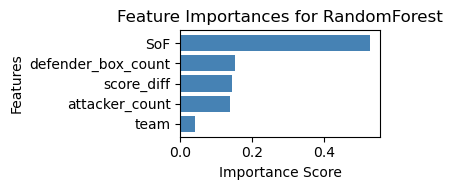

Feature Importances for GradientBoosting:
              Feature  Importance
0                 SoF    0.661836
1  defender_box_count    0.239210
2      attacker_count    0.048578
3          score_diff    0.048217
4                team    0.002159


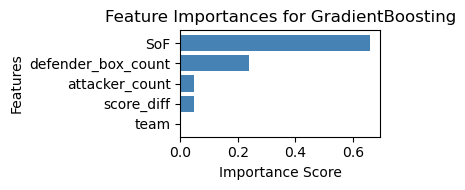

Feature Importances for XGBoost:
              Feature  Importance
0  defender_box_count    0.312636
1                 SoF    0.298537
2      attacker_count    0.172806
3          score_diff    0.128405
4                team    0.087616


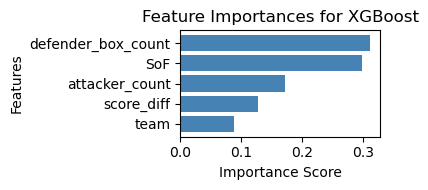

In [39]:
for name, model in best_models.items():
    if hasattr(model, "feature_importances_"):
        print(f"Feature Importances for {name}:")
        
        # Extract feature importance
        feature_importances = model.feature_importances_
        sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
        
        # Create a DataFrame for better visualization
        importance_df = pd.DataFrame({
            "Feature": X_train.columns[sorted_idx],
            "Importance": feature_importances[sorted_idx],
        })
        
        print(importance_df)
        
        # Plot the feature importance
        plt.figure(figsize=(4, 2))
        plt.barh(
            importance_df["Feature"], 
            importance_df["Importance"], 
            color="steelblue"
        )
        plt.gca().invert_yaxis()  # Reverse the order for better readability
        plt.title(f"Feature Importances for {name}")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()

#### Rank Attackers

In [197]:
att_all_counts = sampled_df.recipient_name.value_counts()
att_frequent_players = att_all_counts[att_all_counts >= 20].index

In [200]:
att_sampled_df = sampled_df[sampled_df['recipient_name'].isin(att_frequent_players)]

In [201]:
GradientBoosting = best_models["GradientBoosting"]
att_X_sampled = att_sampled_df[X_train.columns]  
att_sampled_df_predictions = GradientBoosting.predict(att_X_sampled)
att_sampled_df["predictions"] = att_sampled_df_predictions

In [202]:
succeed_difficult = att_sampled_df[(att_sampled_df['predictions'] == 0) & (att_sampled_df['success'] == 1)]

In [204]:
succeess_count = att_sampled_df[att_sampled_df['success'] == 1].recipient_name.value_counts()

In [205]:
difficult_count = att_sampled_df[att_sampled_df['predictions'] == 0].recipient_name.value_counts()

In [206]:
difficult_ratio = difficult_count/att_all_counts
#difficult_ratio[~difficult_ratio.isna()].sort_values(ascending = False)

In [209]:
succeed_difficult_count = succeed_difficult.recipient_name.value_counts()
#succeed_difficult_count

In [34]:
#top10_att_df = model_1_data[model_1_data['pass_recipient_name'].isin(top10_att.index)]
MPD_median = att_sampled_df.groupby('recipient_name')['MPD'].median().sort_values(ascending = False)

In [49]:
model_1_data[model_1_data['possession_team_name'] == 'Chelsea'].recipient_name.value_counts()

pass_recipient_name
N. Charles            140
J. Rytting Kaneryd     63
L. James               59
A. Lawrence            54
G. Reiten              52
È. Périsset            33
F. Kirby               32
E. Cuthbert            27
A. Beever-Jones        26
S. Nüsken              22
J. Canković            20
M. Leupolz             17
S. Kerr                16
J. Carter              15
J. Fleming             13
S. Ingle               12
M. Fishel               9
M. Ramírez              6
C. Macário              5
M. Mjelde               3
M. Hamano               3
M. Bright               2
R. Mace                 1
E. Koivisto             1
J. Rantala              1
A. Palmer               1
B. Mead                 1
Geyse Ferreira          1
S. Tierney              1
Name: count, dtype: int64

In [230]:
succeed_difficult_ratio = succeed_difficult_count/difficult_count
succeed_difficult_ratio_df = pd.DataFrame({
    "success_difficult_ratio": succeed_difficult_ratio,
    'success_count':succeess_count,
    'success_difficult':succeed_difficult_count,
    "all_seq_count": att_all_counts,
    'difficult_count': difficult_count
}).reset_index()
df_values = succeed_difficult_ratio_df[succeed_difficult_ratio_df['difficult_count']>20].sort_values(by = 'success_difficult_ratio', ascending = False)

In [233]:
df_values['success_difficult_ratio'] = df_values['success_difficult_ratio'].round(2)

In [234]:
df_values

,recipient_name,success_difficult_ratio,success_count,success_difficult,all_seq_count,difficult_count
3,Adriana Leon,0.73,30.0,16.0,37,22.0
157,Mary Boio Fowler,0.63,41.0,22.0,59,35.0
119,Kirsty Hanson,0.61,30.0,17.0,42,28.0
47,Ella Toone,0.59,32.0,24.0,53,41.0
34,Chloe Maggie Kelly,0.57,92.0,53.0,142,93.0
37,Cloe Lacasse,0.55,17.0,12.0,36,22.0
25,Caitlin Jade Foord,0.54,68.0,35.0,108,65.0
129,Lauren May Hemp,0.52,48.0,27.0,83,52.0
203,Sarah Emma Mayling,0.52,18.0,14.0,36,27.0
181,Niamh Louise Charles,0.51,58.0,21.0,88,41.0


In [236]:
df_values[['recipient_name', 'success_difficult_ratio', 'success_difficult', 'difficult_count']]\
    .style.format({
        'success_difficult_ratio': "{:.2f}",  # Show 2 decimal places
        'success_difficult': "{:.0f}",  # No decimal places for counts
        'difficult_count': "{:.0f}"  # No decimal places for counts
    })\
    .background_gradient(cmap='Blues')

,recipient_name,success_difficult_ratio,success_difficult,difficult_count
3,Adriana Leon,0.73,16,22
157,Mary Boio Fowler,0.63,22,35
119,Kirsty Hanson,0.61,17,28
47,Ella Toone,0.59,24,41
34,Chloe Maggie Kelly,0.57,53,93
37,Cloe Lacasse,0.55,12,22
25,Caitlin Jade Foord,0.54,35,65
129,Lauren May Hemp,0.52,27,52
203,Sarah Emma Mayling,0.52,14,27
181,Niamh Louise Charles,0.51,21,41


In [211]:
df = succeed_difficult_ratio_df[succeed_difficult_ratio_df['difficult_count']>15]

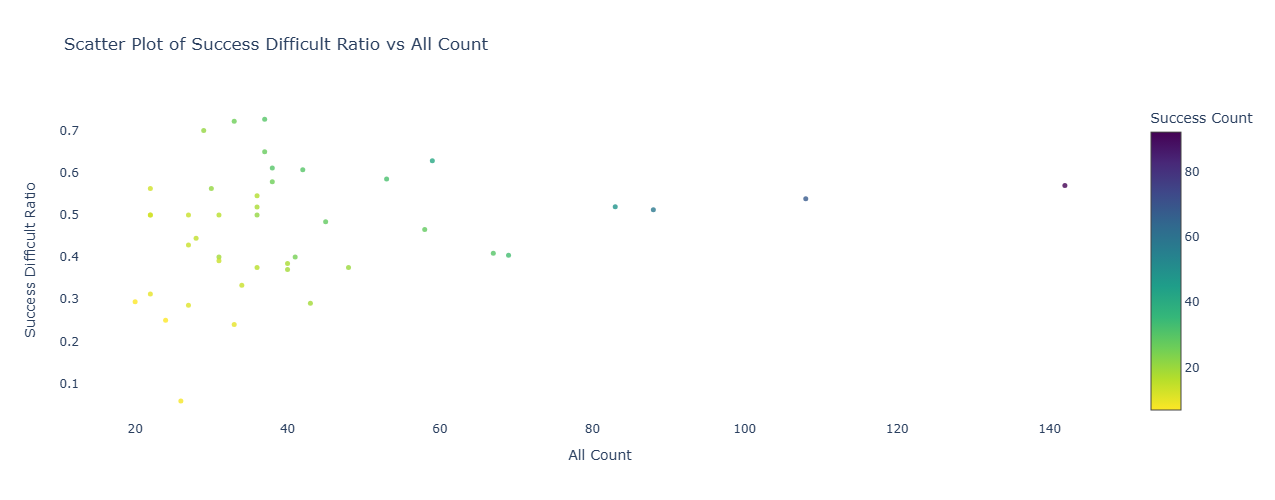

In [217]:
fig = go.Figure()

# Add the scatter trace
fig.add_trace(go.Scatter(
    x=df['all_count'],  # X-axis values
    y=df['success_difficult_ratio'],               # Y-axis values
    mode='markers', text=df['recipient_name'],                                           # Scatter plot
    marker=dict(
        size=5,                                               # Marker size
        color=df['success_count'],  
        colorscale='Viridis',  reversescale=True, # Choose a color scale (e.g., 'Viridis', 'Plasma', 'Cividis')
        showscale=True,  # Show color legend
        colorbar=dict(title="Success Count"), # Marker color
        opacity=0.8                                          # Transparency of the markers
    ),
    name='Data Points'                                        # Legend name
))
fig.update_layout(
    title='Scatter Plot of Success Difficult Ratio vs All Count',
    xaxis_title='All Count',
    yaxis_title='Success Difficult Ratio', plot_bgcolor='white',
    width=700, height=500
)

#### MPD

In [141]:
def plot_MPD(player_A_df, player_B_df, player_A, player_B, bins = 20):
    plt.figure(figsize=(6,4))
    sns.histplot(player_A_df.MPD, kde=True, color="steelblue", element="step", label=player_A, stat="density", bins= bins, alpha=0.3,
                        linewidth=0.3)
    sns.histplot(player_B_df.MPD, kde=True, color="sienna", element="step", label=player_B, stat="density", bins= bins, alpha=0.3,
                        linewidth=0.3)

    plt.xlabel("MPD", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.4)
    plt.show()

85 36


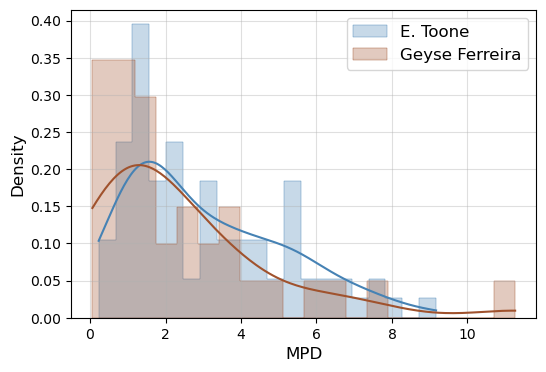

In [129]:
player_A = 'E. Toone'
player_B = 'Geyse Ferreira'
player_A_df = model_1_data[model_1_data['pass_recipient_name'] == player_A]
player_B_df = model_1_data[model_1_data['pass_recipient_name'] == player_B]
print(len(player_A_df), len(player_B_df))
plot_MPD(player_A_df, player_B_df)

In [151]:
select_df = model_1_data[model_1_data['pass_recipient_name'] == 'F. Morgan']

651 490


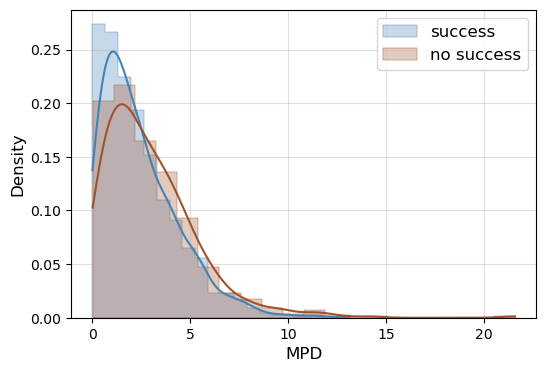

In [156]:
success = sampled_df[(sampled_df['success'] == 1) & (sampled_df['predictions'] == 0)]
no_success = sampled_df[(sampled_df['success'] == 0) & (sampled_df['predictions'] == 1)]
print(len(success), len(no_success))
plot_MPD(success, no_success, 'success', 'no success', bins = 20)

#### Rank Defender

In [239]:
features = ["score_diff", "SoF", "attacker_count", "team", "defender_count"]
target = "success"
X = model_training[features]
y = model_training[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [240]:
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20],
        },
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=500),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["liblinear", "lbfgs"],
        },
    },
    "KNeighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
}

# Perform GridSearchCV for each model
best_models = {}
for name, entry in models.items():
    print(f"Optimizing {name}...")
    grid = GridSearchCV(entry["model"], entry["params"], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best cross-validated accuracy for {name}: {grid.best_score_:.4f}\n")

# Compare performance on the test set
print("Performance Comparison:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

Optimizing RandomForest...
Best params for RandomForest: {'max_depth': 10, 'n_estimators': 50}
Best cross-validated accuracy for RandomForest: 0.6069

Optimizing GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Best cross-validated accuracy for GradientBoosting: 0.6044

Optimizing LogisticRegression...
Best params for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated accuracy for LogisticRegression: 0.5927

Optimizing KNeighbors...
Best params for KNeighbors: {'n_neighbors': 7, 'weights': 'distance'}
Best cross-validated accuracy for KNeighbors: 0.6141

Optimizing XGBoost...
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best cross-validated accuracy for XGBoost: 0.6044

Performance Comparison:
Model: RandomForest
Accuracy: 0.5996
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.61     

In [76]:
sampled_df.shape

(3392, 64)

In [14]:
df_all_counts = sampled_df.paired_player.value_counts()
df_frequent_players = df_all_counts[df_all_counts >= 0].index

In [15]:
df_sampled_df = sampled_df[sampled_df['paired_player'].isin(df_frequent_players)]

In [16]:
df_sampled_df.shape

(3392, 64)

In [17]:
GradientBoosting = best_models["GradientBoosting"]
X_sampled = df_sampled_df[X_train.columns]  
df_sampled_df_predictions = GradientBoosting.predict(X_sampled)
df_sampled_df["predictions"] = df_sampled_df_predictions

In [18]:
unsucceed_easy = df_sampled_df[(df_sampled_df['predictions'] == 1) & (df_sampled_df['success'] == 0)]

In [19]:
unsucceed_easy_count = unsucceed_easy.paired_player.value_counts()

In [20]:
difficult = df_sampled_df[df_sampled_df['predictions'] == 0]
difficult_count = difficult.paired_player.value_counts()

In [21]:
easy_count = df_sampled_df[df_sampled_df['predictions'] == 1].paired_player.value_counts()

In [260]:
df_sampled_df[(df_sampled_df['paired_player'] == 'Amalie Grønbak Thestrup') & (df_sampled_df['predictions'] == 1)]

,sk_match_id,frame,minute,player_name,pass_recipient_name,pass_recipient_id,pass_recipient_position,sk_player_id,pass_angle,type_primary,type_secondary,location_x,location_y,pass_accurate,team_name,possession_team_name,possession_team_name_src,possession_types,period,receive_frame,receive_x,receive_y,target_area,ball_x_0,ball_y_0,ball_x_1,ball_y_1,player_x_1,player_y_1,player_1,ball_x_2,ball_y_2,player_x_2,player_y_2,player_2,ball_x_3,ball_y_3,player_x_3,player_y_3,player_3,sk_recipient_id,long_name,dist_0,dist_1,dist_2,dist_3,score_1,score_2,score_3,attack_score,defend_score,SoF,defender_box_count,attacker_count,defender_count,team,paired_player_id,paired_player,min_distance,MPD,recipient_name,score_diff,success,ball_dist_1,predictions
940,1169170,7183,11,F. Angeldahl,E. Morgan,498738,RB,42753.0,-121,pass,['recovery' 'counterpressing_recovery' 'short_or_medium_pass'],79,91,True,Manchester City,Manchester City,In Contest,['attack'],1.0,7190.0,25.51,-20.86,True,25.55,-22.68,27.53,-11.05,26.99,-15.51,57072.0,47.12,22.54,45.25,20.81,22604.0,43.58,11.13,42.50,13.20,22604.0,57072,Esme Beth Morgan,34.111577,29.854986,22.036756,16.560193,1,1,1,1,0,68.877867,4,7,9,1,151759,Amalie Grønbak Thestrup,7.859268,6.762869,Esme Beth Morgan,1,1,4.492572,1
926,1169170,6155,10,C. Kelly,Y. Hasegawa,238894,DMF,57068.0,-138,pass,['back_pass' 'short_or_medium_pass'],81,94,True,Manchester City,Manchester City,Manchester City,['attack'],1.0,6162.0,24.21,-22.16,True,24.65,-23.97,19.89,-22.02,22.64,-20.25,22684.0,15.90,-23.83,15.43,-23.34,57072.0,28.01,-31.96,25.74,-31.28,57068.0,22684,Yui Hasegawa,35.935911,36.078832,43.805713,41.164742,0,0,0,1,0,49.734457,4,5,9,1,151759,Amalie Grønbak Thestrup,1.790754,1.786309,Yui Hasegawa,1,0,3.270382,1
949,1169170,12499,20,Y. Hasegawa,A. Greenwood,11186,LB,22684.0,94,pass,['lateral_pass' 'short_or_medium_pass'],69,62,True,Manchester City,Manchester City,Manchester City,['set_piece_attack' 'attack' 'free_kick'],1.0,12510.0,19.21,-21.46,True,19.54,-19.68,18.38,-19.54,19.34,-21.15,22604.0,6.11,-5.86,0.68,3.47,64095.0,11.22,-16.38,12.43,-16.47,22684.0,22604,Alex Greenwood,39.607521,39.330753,51.936050,43.322809,0,0,0,1,0,120.841999,6,8,10,1,151759,Amalie Grønbak Thestrup,8.911678,5.261688,Alex Greenwood,1,0,1.874487,1
950,1169170,12584,20,Y. Hasegawa,A. Greenwood,11186,LB,22684.0,18,pass,['forward_pass' 'pass_to_final_third' 'short_or_medium_pass'],63,70,True,Manchester City,Manchester City,Manchester City,['set_piece_attack' 'attack' 'free_kick'],1.0,12596.0,21.27,-28.70,True,20.87,-26.85,22.83,-20.71,23.60,-24.81,22604.0,10.43,-6.70,22.95,-3.32,64095.0,17.53,9.80,18.74,-15.94,22604.0,22604,Alex Greenwood,42.414654,38.088661,29.735919,37.333915,1,1,1,1,0,88.918393,0,6,8,1,151759,Amalie Grønbak Thestrup,11.986634,10.401793,Alex Greenwood,1,1,4.171678,1
1577,1227893,46009,72,S. Cooke,K. Smith,62816,LB,541766.0,-50,pass,['lateral_pass' 'pass_to_final_third' 'short_or_medium_pass'],57,47,True,West Ham United,West Ham United,West Ham United,['attack'],2.0,46028.0,-23.48,-26.23,True,-23.70,-24.70,-30.21,-28.93,-28.54,-28.98,22626.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22626,Kirsty Smith,37.300446,36.060671,NaN,NaN,0,0,0,1,3,96.281956,0,6,9,1,151759,Amalie Grønbak Thestrup,9.523665,7.793633,Kirsty Smith,-2,0,1.670748,1
1756,1245009,46138,66,S. Mayling,A. Patten,353249,RCB,68672.0,-155,pass,['back_pass' 'short_or_medium_pass'],78,94,True,Aston Villa,Aston Villa,Aston Villa,['attack'],2.0,46151.0,-17.60,25.77,True,-19.57,25.92,-17.00,23.77,-17.78,25.63,68719.0,-22.39,4.06,-20.41,3.91,68680.0,NaN,NaN,NaN,NaN,NaN,68719,Anna Patten,43.383210,43.155246,32.327329,NaN,0,1,0,0,0,42.972448,4,6,10,0,151759,Amalie Grønbak Thestrup,7.698110,0.580000,Anna Patten,0,1,2.016928,1
2279,1260796,7835,12,N. Sørensen,J. Vanhaevermaet,39278,RCMF,63762.0,-142,pass,['back_pass' 'short_or_medium_pass'],84,95,True,Everton,Everton,Everton,['attack' 'throw_in'],1.0,7843.0,24.96,-28.55,True,26.74,-29.14,22.82,-24.62,23.13,-25.52,63651.0,19.16,-1.15,19.

In [22]:
unsucceed_easy_ratio = unsucceed_easy_count/easy_count
unsucceed_easy_ratio_df = pd.DataFrame({
    "unsuccess_easy_ratio": unsucceed_easy_ratio,
    'unsucceed_easy': unsucceed_easy_count,
    "easy_count": easy_count,
    "difficult_count": difficult_count,
    "df_all_counts": df_all_counts
})
unsucceed_easy_ratio_df = unsucceed_easy_ratio_df[unsucceed_easy_ratio_df['easy_count'] >= 10]
df_defender = unsucceed_easy_ratio_df.sort_values(by = 'unsucceed_easy', ascending = False).reset_index()

In [23]:
df_defender[['paired_player', 'unsuccess_easy_ratio', 'unsucceed_easy', 'easy_count', "difficult_count"]]\
    .style.format({
        'unsuccess_easy_ratio': "{:.2f}",  # Show 2 decimal places
        'unsucceed_easy': "{:.0f}",  # No decimal places for counts
        'easy_count': "{:.0f}",  # No decimal places for counts
        "difficult_count": "{:.0f}"
    })\
    .background_gradient(cmap='Blues')

,paired_player,unsuccess_easy_ratio,unsucceed_easy,easy_count,difficult_count
0,Ella Mae Florence Powell,0.34,15,44,46
1,Heather Payne,0.31,10,32,44
2,Niamh Louise Charles,0.47,9,19,27
3,Sarah Emma Mayling,0.31,8,26,45
4,Mayumi Pacheco,0.37,7,19,38
5,Jamie-Lee Napier,0.28,7,25,57
6,Ashleigh Neville,0.39,7,18,24
7,Kerstin Yasmijn Casparij,0.41,7,17,11
8,Aurora Galli,0.40,6,15,18
9,Leila Ouahabi El Ouahabi,0.46,6,13,13
